Loading C:\Users\oscar\mne_data\MNE-fNIRS-motor-data\Participant-1


Reading 0 ... 23238  =      0.000 ...  2974.464 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1291 samples (165.248 s)

Used Annotations descriptions: ['Control', 'Tapping/Left', 'Tapping/Right']
Not setting metadata
90 matching events found
Setting baseline interval to [-4.992, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 90 events and 157 original time points ...
    Rejecting  epoch based on HBO : ['S4_D4 hbo']
    Rejecting 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


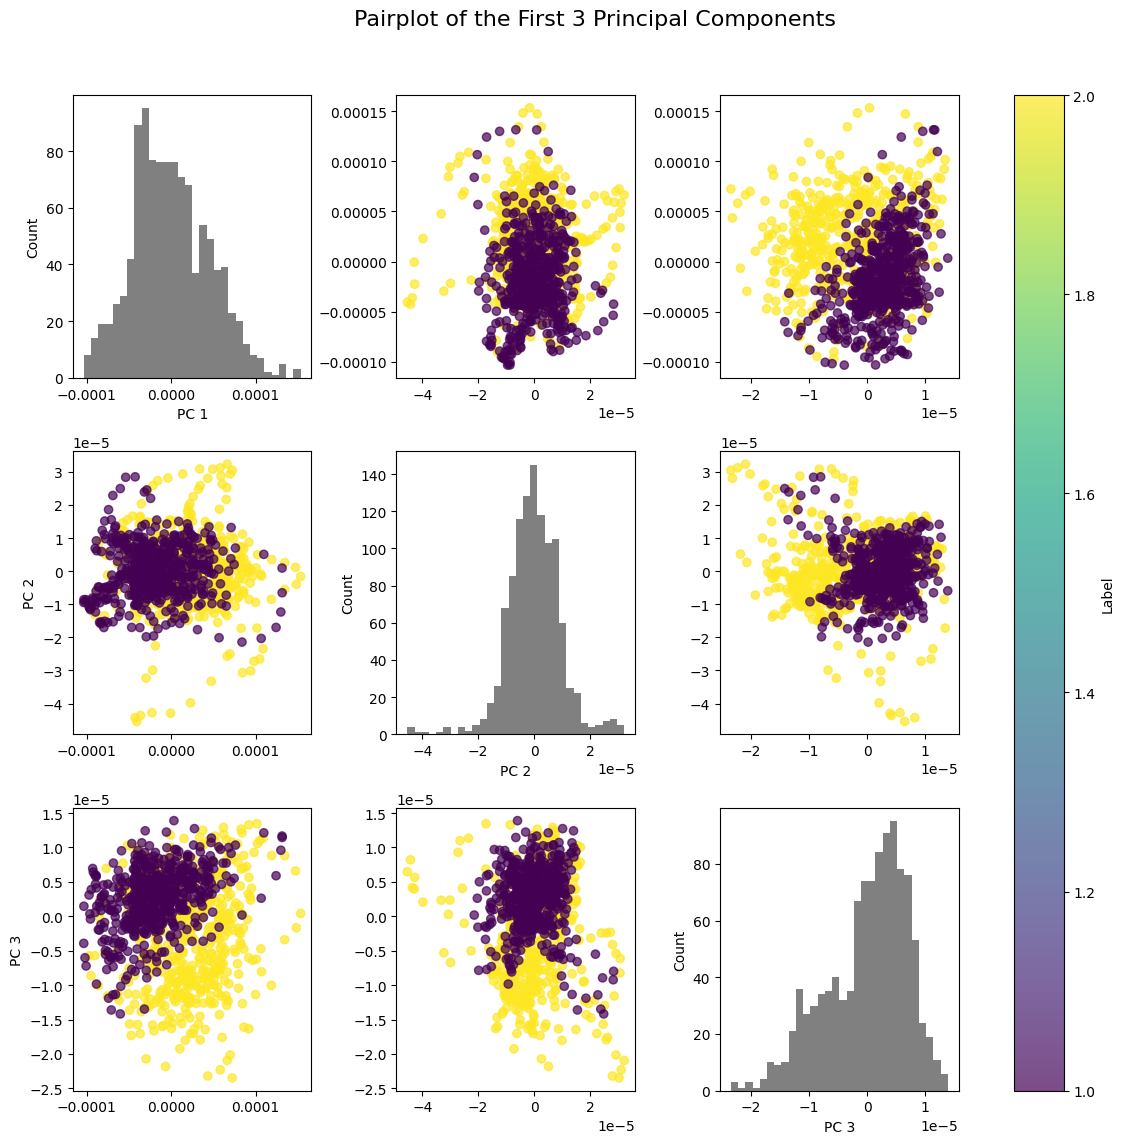

In [ ]:
from itertools import compress
import numpy as np
import mne
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def load_raw_data():
    """
    Downloads and loads the fNIRS dataset and performs initial annotations.
    Returns:
        raw_intensity: The raw intensity MNE object.
    """
    # Downloading and loading dataset
    fnirs_data_folder = mne.datasets.fnirs_motor.data_path()
    fnirs_cw_amplitude_dir = fnirs_data_folder / "Participant-1"
    raw_intensity = mne.io.read_raw_nirx(fnirs_cw_amplitude_dir, verbose=True)
    raw_intensity.load_data()

    # Annotating and removing unnecessary trigger codes
    raw_intensity.annotations.set_durations(5)
    raw_intensity.annotations.rename(
        {"1.0": "Control", "2.0": "Tapping/Left", "3.0": "Tapping/Right"}
    )
    unwanted = np.nonzero(raw_intensity.annotations.description == "15.0")
    raw_intensity.annotations.delete(unwanted)

    return raw_intensity


def preprocess_raw_data(raw_intensity):
    """
    Preprocess raw intensity data into haemoglobin concentration
    by applying channel selection, conversion to optical density,
    checking scalp coupling, conversion to haemoglobin, and filtering.
    Args:
        raw_intensity: The raw intensity MNE object.
    Returns:
        raw_haemo: The preprocessed haemoglobin concentration MNE object.
    """
    # Remove short channels for neural responses
    picks = mne.pick_types(raw_intensity.info, meg=False, fnirs=True)
    dists = mne.preprocessing.nirs.source_detector_distances(raw_intensity.info, picks=picks)
    raw_intensity.pick(picks[dists > 0.01])

    # Convert raw intensity to optical density
    raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)

    # Check the quality of the coupling between the scalp and the optodes
    sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od)
    raw_od.info["bads"] = list(compress(raw_od.ch_names, sci < 0.5))

    # Convert from optical density to haemoglobin concentration using the Beer-Lambert law
    raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od, ppf=0.1)

    # Filtering: apply band pass filter to remove heartbeat and slow drifts
    raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2, l_trans_bandwidth=0.02)

    return raw_haemo


def extract_epochs(raw_haemo, tmin=-5, tmax=15):
    """
    Extracts epochs from preprocessed data.
    Args:
        raw_haemo: Preprocessed MNE object with haemoglobin concentration.
        tmin: Start time before the event.
        tmax: End time after the event.
    Returns:
        epochs: The extracted epochs.
    """
    events, event_dict = mne.events_from_annotations(raw_haemo)
    # Define rejection criteria: any channel exceeding 80e-6 is considered too noisy.
    reject_criteria = dict(hbo=80e-6)
    epochs = mne.Epochs(
        raw_haemo,
        events,
        event_id=event_dict,
        tmin=tmin,
        tmax=tmax,
        reject=reject_criteria,
        reject_by_annotation=True,
        proj=True,
        baseline=(None, 0),
        preload=True,
        detrend=None,
        verbose=True,
    )
    return epochs


def get_epochs():
    """
    Pipeline for loading, preprocessing, and extracting epochs.
    Returns:
        epochs: The extracted epochs.
    """
    raw_intensity = load_raw_data()
    raw_haemo = preprocess_raw_data(raw_intensity)
    epochs = extract_epochs(raw_haemo)
    return epochs


def compute_segment_power(data, label_value, seg_samples):
    """
    Computes the mean features for each segment in the provided data.
    Each segment is extracted from an epoch and its mean is calculated
    along the time axis.
    
    Args:
        data (ndarray): Array of epochs with shape (n_epochs, n_channels, n_times)
        label_value (int): Label value to assign to each segment from these epochs

    Returns:
        tuple: A tuple containing:
            - segs (ndarray): Array of mean features for each segment.
            - seg_labels (ndarray): Array of corresponding label values.
    """
    segs, seg_labels = [], []
    # Loop over each epoch in the data
    for epoch in data:
        n_time = epoch.shape[1]  # total time samples in the epoch
        n_segs = n_time // seg_samples  # number of full segments that can be extracted
        # Iterate over each segment in the epoch
        for i in range(n_segs):
            # Extract the segment for all channels
            segment = epoch[:, i * seg_samples : (i + 1) * seg_samples]
            # Compute mean power as the average squared value for each channel in this segment
            mean_val = np.mean(segment, axis=1)
            # Append the computed mean and corresponding label
            segs.append(mean_val)
            seg_labels.append(label_value)
    return np.array(segs), np.array(seg_labels)

# Function to stack the epochs for left tapping and control and split them into s second windows
def stack_epochs(epochs, s, tmin=0, tmax=10):
    """
    Stacks epochs for left tapping and control and splits them into
    s second windows."
    """
    data = epochs.copy().crop(tmin=tmin, tmax=tmax).get_data()
    labels = epochs.events[:, -1]  # getting labels from epoch events
    # Stack epochs for left tapping and control
    left_tapping = data[labels == 2]
    control = data[labels == 1]

    # Get the sampling frequency from the epochs object
    sfreq = epochs.info["sfreq"]
    # Calculate the number of samples per segment based on the window length (s seconds)
    seg_samples = int(s * sfreq)

    # Compute power features for left tapping segments (label 2)
    left_features, left_labels = compute_segment_power(left_tapping, 2, seg_samples)
    # Compute power features for control segments (label 1)
    control_features, control_labels = compute_segment_power(control, 1, seg_samples)

    # Concatenate the features and labels from both conditions
    X = np.concatenate([left_features, control_features], axis=0)
    y = np.concatenate([left_labels, control_labels], axis=0)

    return X, y

    # Print the sampling rate per second
    # Computing the PCA for the stacked epochs
    # Compute features and labels from the stacked epochs
    window_length = 0.55  # seconds #NOTE: set to 0.128 seconds for every sample
    X, y = stack_epochs(get_epochs(), s=window_length)

    # Perform PCA reducing to 4 components
    nr_pcs = 3
    pca = PCA(n_components=nr_pcs)
    X_pca = pca.fit_transform(X)

    # Create a grid of plots for the first 4 principal components
    fig, axes = plt.subplots(nr_pcs, nr_pcs, figsize=(12, 12))
    pcs = ['PC 1', 'PC 2', 'PC 3']

    for i in range(nr_pcs):
        for j in range(nr_pcs):
            ax = axes[i, j]
            if i == j:
                # Plot a histogram on the diagonal
                ax.hist(X_pca[:, i], bins=30, color='gray')
                ax.set_xlabel(pcs[i])
                ax.set_ylabel('Count')
                # Show explained variance above the plot
                ev = pca.explained_variance_ratio_[i] * 100
                ax.text(0.5, 0.95, f'Explained Variance: {ev:.1f}%', transform=ax.transAxes,
                        ha='center', va='top', fontsize=10, fontweight='bold')
            else:
                # Scatter plot for the off-diagonals
                sc = ax.scatter(X_pca[:, j], X_pca[:, i], c=y, cmap='viridis', alpha=0.7)
                if i == nr_pcs - 1:
                    ax.set_xlabel(pcs[j])
                if j == 0:
                    ax.set_ylabel(pcs[i])

    plt.suptitle(f'Pairplot of the First {nr_pcs} Principal Components', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.colorbar(sc, ax=axes.ravel().tolist(), label='Label')
    plt.show()